# S3D Experiment Tracker
## Hyperparameter Optimization Experiments

This notebook tracks all S3D model experiments with validation loss, accuracy, and conclusions.

**Usage:**
1. Run all cells to see current results
2. Add new experiments using the `add_experiment()` function
3. Save experiments with `save_experiments()`
4. Visualizations auto-update with new data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import os

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Imports successful")

✓ Imports successful


## 1. Data Management Functions

In [2]:
# File to store experiments
EXPERIMENT_FILE = 'experiments.json'

def load_experiments():
    """Load experiments from JSON file or return default data"""
    if os.path.exists(EXPERIMENT_FILE):
        with open(EXPERIMENT_FILE, 'r') as f:
            return pd.DataFrame(json.load(f))
    else:
        # Default experiments from your notes
        return pd.DataFrame([
            {"id": 13, "name": "hframe_hwd", "val_loss": 1.85474, "val_acc": 68.3432, 
             "config": "Original baseline", "conclusion": "don't increase backbone_init_lr", 
             "change": "baseline", "date": "2024-01-01"},
            {"id": 14, "name": "hframe_hwd1", "val_loss": 2.22761, "val_acc": 62.42604, 
             "config": "backbone_init_lr: 1e-4 (x10)", "conclusion": "experiment more with lr scheduler", 
             "change": "worse", "date": "2024-01-02"},
            {"id": 15, "name": "hframe_hwd1_nosched", "val_loss": 2.23484, "val_acc": 61.2426, 
             "config": "No LR scheduler", "conclusion": "maybe increase backbone_weight_decay", 
             "change": "worse", "date": "2024-01-03"},
            {"id": 16, "name": "hframe_mwd", "val_loss": 2.18403, "val_acc": 60.65089, 
             "config": "backbone_weight_decay: 1e-4", "conclusion": "inconclusive, vary eps by less", 
             "change": "worse", "date": "2024-01-04"},
            {"id": 17, "name": "hframe_hwd_leps", "val_loss": 1.89451, "val_acc": 65.68047, 
             "config": "Adam eps: 1e-8", "conclusion": "still worse, vary eps by less", 
             "change": "worse", "date": "2024-01-05"},
            {"id": 18, "name": "hframe_hwd_leps2", "val_loss": 1.93781, "val_acc": 68.3432, 
             "config": "Adam eps: 1e-7", "conclusion": "still worse in loss, better in acc", 
             "change": "worse", "date": "2024-01-06"},
            {"id": 19, "name": "hframe_hwd_leps3", "val_loss": 1.95846, "val_acc": 69.52663, 
             "config": "Adam eps: 1e-6", "conclusion": "improvement in acc but worse in loss", 
             "change": "worse", "date": "2024-01-07"},
            {"id": 20, "name": "hframe_hwd_leps4", "val_loss": 1.72448, "val_acc": 73.66864, 
             "config": "Adam eps: 1e-5", "conclusion": "an improvement", 
             "change": "better", "date": "2024-01-08"},
            {"id": 21, "name": "hframe_hwd_leps5", "val_loss": 1.66771, "val_acc": 73.37278, 
             "config": "Adam eps: 1e-4", "conclusion": "slight improvement in loss, acc declines", 
             "change": "better", "date": "2024-01-09"},
            {"id": 22, "name": "hframe_hwd_warmups", "val_loss": 1.64363, "val_acc": 71.89349, 
             "config": "With warmups", "conclusion": "experiment with warm restarts", 
             "change": "better", "date": "2024-01-10"},
            {"id": 23, "name": "hframe_hwd_warmrestarts", "val_loss": 1.44793, "val_acc": 71.30178, 
             "config": "Warm restarts, eta_min=0", "conclusion": "experiment with lower eta_min", 
             "change": "better", "date": "2024-01-11"},
            {"id": 24, "name": "hf_hwd_eps_dp01", "val_loss": 4.66636, "val_acc": 21.59763, 
             "config": "Dropout: 0.1", "conclusion": "don't go this low", 
             "change": "much worse", "date": "2024-01-12"},
            {"id": 25, "name": "hframe_hwd_leps6", "val_loss": 1.9324, "val_acc": 68.9349, 
             "config": "Adam eps: 1e-3", "conclusion": "decrease in loss and accuracy", 
             "change": "worse", "date": "2024-01-13"},
            {"id": 26, "name": "hframe_hwd_leps7", "val_loss": 1.5451, "val_acc": 70.4142, 
             "config": "Adam eps: 1e-2", "conclusion": "keep eps here or 1e-4", 
             "change": "better", "date": "2024-01-14"},
            {"id": 27, "name": "hframe_hwd_warmrestarts2", "val_loss": 1.6258, "val_acc": 71.0059, 
             "config": "Warm restarts (default eta_min)", "conclusion": "experiment with dropout", 
             "change": "better", "date": "2024-01-15"},
            {"id": 28, "name": "hf_hwd_eps_wups_restarts", "val_loss": 1.5499, "val_acc": 69.8225, 
             "config": "Warmups + Warm restarts", "conclusion": "both combined reduced loss", 
             "change": "better", "date": "2024-01-16"},
            {"id": 29, "name": "hf_hwd_eps_dp02", "val_loss": 1.9626, "val_acc": 67.4556, 
             "config": "Dropout: 0.2", "conclusion": "add more dropout", 
             "change": "worse", "date": "2024-01-17"},
            {"id": 30, "name": "hf_hwd_eps_dp03", "val_loss": 2.0132, "val_acc": 68.6391, 
             "config": "Dropout: 0.3", "conclusion": "maybe add more dropout", 
             "change": "worse", "date": "2024-01-18"},
            {"id": 31, "name": "hf_hwd_eps_dp04", "val_loss": 1.6876, "val_acc": 73.3728, 
             "config": "Dropout: 0.4", "conclusion": "not much diff", 
             "change": "better", "date": "2024-01-19"},
            {"id": 32, "name": "hf_hwd_eps_dp06", "val_loss": 1.7299, "val_acc": 73.0769, 
             "config": "Dropout: 0.6", "conclusion": "a bit better than 0.4", 
             "change": "worse", "date": "2024-01-20"},
            {"id": 33, "name": "hf_hwd_eps_dp07", "val_loss": 1.6676, "val_acc": 74.8521, 
             "config": "Dropout: 0.7", "conclusion": "drop_p 0.4-0.7 seems fine", 
             "change": "better", "date": "2024-01-21"},
            {"id": 34, "name": "hf_hwd_eps_hbs", "val_loss": 1.7605, "val_acc": 70.7101, 
             "config": "Batch size 8, drop_p=0.1", "conclusion": "can use batch size of 8", 
             "change": "worse", "date": "2024-01-22"},
            {"id": 35, "name": "wups_restarts_et0", "val_loss": 1.5235, "val_acc": 69.2308, 
             "config": "Warmups + restarts, eta_min=0", "conclusion": "slightly better with eta_min=0", 
             "change": "better", "date": "2024-01-23"},
            {"id": 36, "name": "wups_restarts_eps2", "val_loss": 1.6228, "val_acc": 69.8225, 
             "config": "Warmups + restarts, eps=1e-2", "conclusion": "don't set eps to e-2", 
             "change": "worse", "date": "2024-01-24"},
            {"id": 37, "name": "wups_restarts_eps4", "val_loss": 1.4899, "val_acc": 70.7101, 
             "config": "Warmups + restarts, eps=1e-4", "conclusion": "set eps to -4, but -5 fine", 
             "change": "better", "date": "2024-01-25"},
        ])

def save_experiments(df):
    """Save experiments to JSON file"""
    df.to_json(EXPERIMENT_FILE, orient='records', indent=2)
    print(f"✓ Saved {len(df)} experiments to {EXPERIMENT_FILE}")

def add_experiment(name, val_loss, val_acc, config, conclusion, change='unknown'):
    """Add a new experiment to the dataframe"""
    global df_experiments
    
    new_id = df_experiments['id'].max() + 1
    new_exp = pd.DataFrame([{
        'id': new_id,
        'name': name,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'config': config,
        'conclusion': conclusion,
        'change': change,
        'date': datetime.now().strftime('%Y-%m-%d')
    }])
    
    df_experiments = pd.concat([df_experiments, new_exp], ignore_index=True)
    print(f"✓ Added experiment S3D {new_id}: {name}")
    print(f"  Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.2f}%")
    return df_experiments

print("✓ Functions defined")

✓ Functions defined


## 2. Load Experiments

In [3]:
# Load all experiments
df_experiments = load_experiments()

print(f"Loaded {len(df_experiments)} experiments")
print(f"Date range: {df_experiments['date'].min()} to {df_experiments['date'].max()}")
print(f"\nBest validation loss: {df_experiments['val_loss'].min():.5f} (S3D {df_experiments.loc[df_experiments['val_loss'].idxmin(), 'id']})")
print(f"Best validation accuracy: {df_experiments['val_acc'].max():.2f}% (S3D {df_experiments.loc[df_experiments['val_acc'].idxmax(), 'id']})")

Loaded 25 experiments
Date range: 2024-01-01 to 2024-01-25

Best validation loss: 1.44793 (S3D 23)
Best validation accuracy: 74.85% (S3D 33)


## 3. Experiment Summary

In [4]:
# Display all experiments
df_display = df_experiments[['id', 'name', 'val_loss', 'val_acc', 'config', 'change']].copy()
df_display.columns = ['ID', 'Name', 'Val Loss', 'Val Acc (%)', 'Configuration', 'Result']

# Style the dataframe
def highlight_best(s):
    if s.name == 'Val Loss':
        is_min = s == s.min()
        return ['background-color: lightgreen' if v else '' for v in is_min]
    elif s.name == 'Val Acc (%)':
        is_max = s == s.max()
        return ['background-color: lightblue' if v else '' for v in is_max]
    return ['' for _ in s]

styled_df = df_display.style.apply(highlight_best)
styled_df

,ID,Name,Val Loss,Val Acc (%),Configuration,Result
0,13,hframe_hwd,1.854740,68.343200,Original baseline,baseline
1,14,hframe_hwd1,2.227610,62.426040,backbone_init_lr: 1e-4 (x10),worse
2,15,hframe_hwd1_nosched,2.234840,61.242600,No LR scheduler,worse
3,16,hframe_mwd,2.184030,60.650890,backbone_weight_decay: 1e-4,worse
4,17,hframe_hwd_leps,1.894510,65.680470,Adam eps: 1e-8,worse
5,18,hframe_hwd_leps2,1.937810,68.343200,Adam eps: 1e-7,worse
6,19,hframe_hwd_leps3,1.958460,69.526630,Adam eps: 1e-6,worse
7,20,hframe_hwd_leps4,1.724480,73.668640,Adam eps: 1e-5,better
8,21,hframe_hwd_leps5,1.667710,73.372780,Adam eps: 1e-4,better
9,22,hframe_hwd_warmups,1.643630,71.893490,With warmups,better


## 4. Visualizations

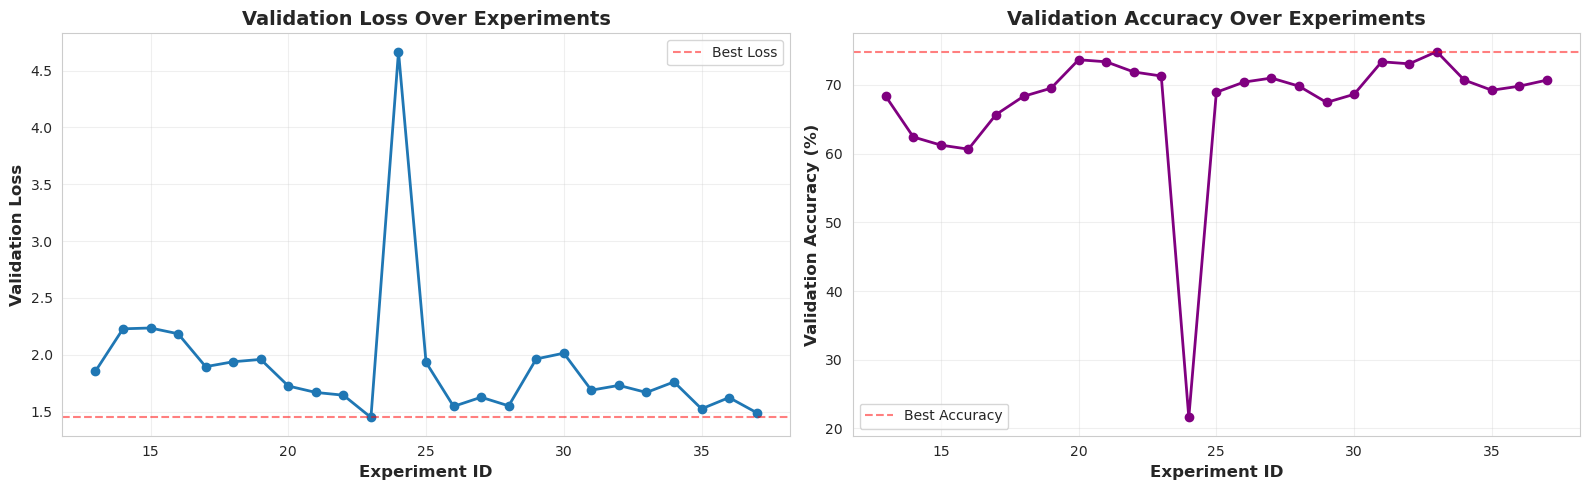

In [5]:
# Performance over time
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Validation Loss
axes[0].plot(df_experiments['id'], df_experiments['val_loss'], marker='o', linewidth=2, markersize=6)
axes[0].axhline(y=df_experiments['val_loss'].min(), color='r', linestyle='--', alpha=0.5, label='Best Loss')
axes[0].set_xlabel('Experiment ID', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Validation Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Validation Loss Over Experiments', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation Accuracy
axes[1].plot(df_experiments['id'], df_experiments['val_acc'], marker='o', color='purple', linewidth=2, markersize=6)
axes[1].axhline(y=df_experiments['val_acc'].max(), color='r', linestyle='--', alpha=0.5, label='Best Accuracy')
axes[1].set_xlabel('Experiment ID', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Validation Accuracy Over Experiments', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

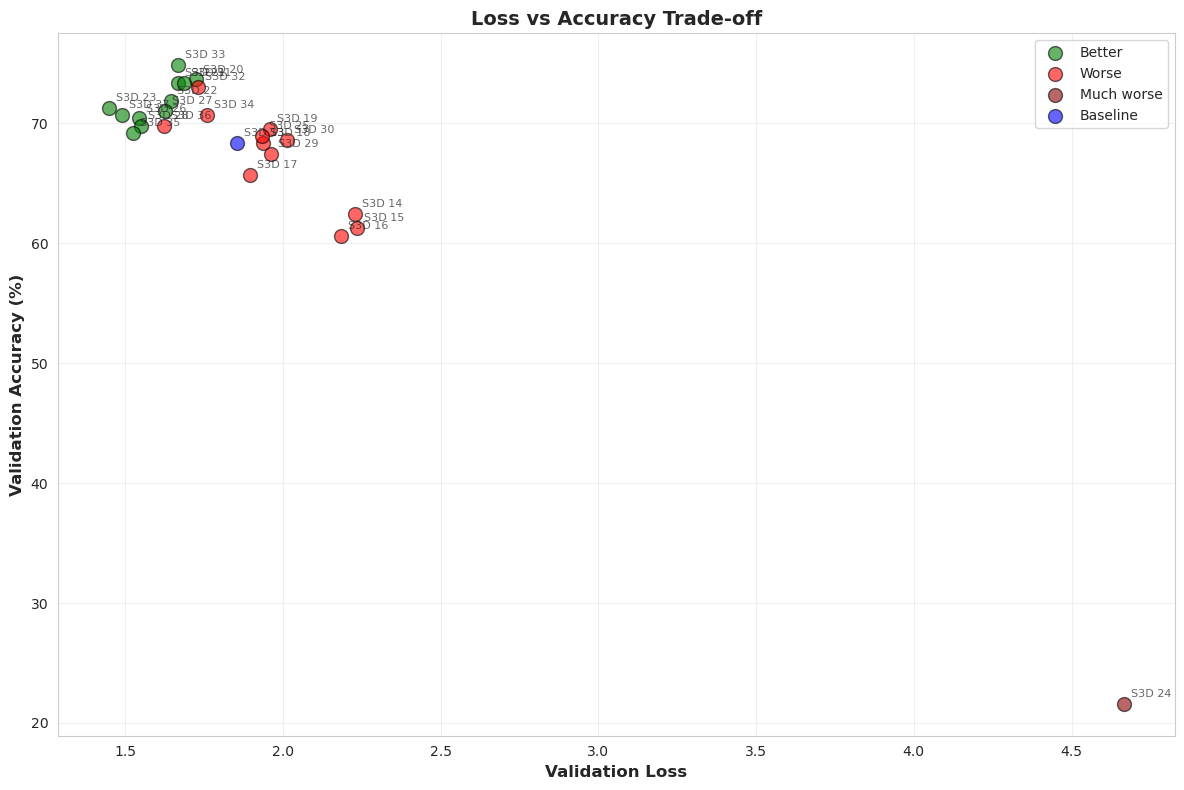

In [6]:
# Loss vs Accuracy scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Color by result
colors = {'better': 'green', 'worse': 'red', 'much worse': 'darkred', 'baseline': 'blue', 'unknown': 'gray'}
for change_type, color in colors.items():
    mask = df_experiments['change'] == change_type
    if mask.any():
        ax.scatter(df_experiments[mask]['val_loss'], 
                  df_experiments[mask]['val_acc'],
                  c=color, label=change_type.capitalize(), s=100, alpha=0.6, edgecolors='black')

# Annotate points
for _, row in df_experiments.iterrows():
    ax.annotate(f"S3D {row['id']}", 
               (row['val_loss'], row['val_acc']),
               xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

ax.set_xlabel('Validation Loss', fontsize=12, fontweight='bold')
ax.set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Loss vs Accuracy Trade-off', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

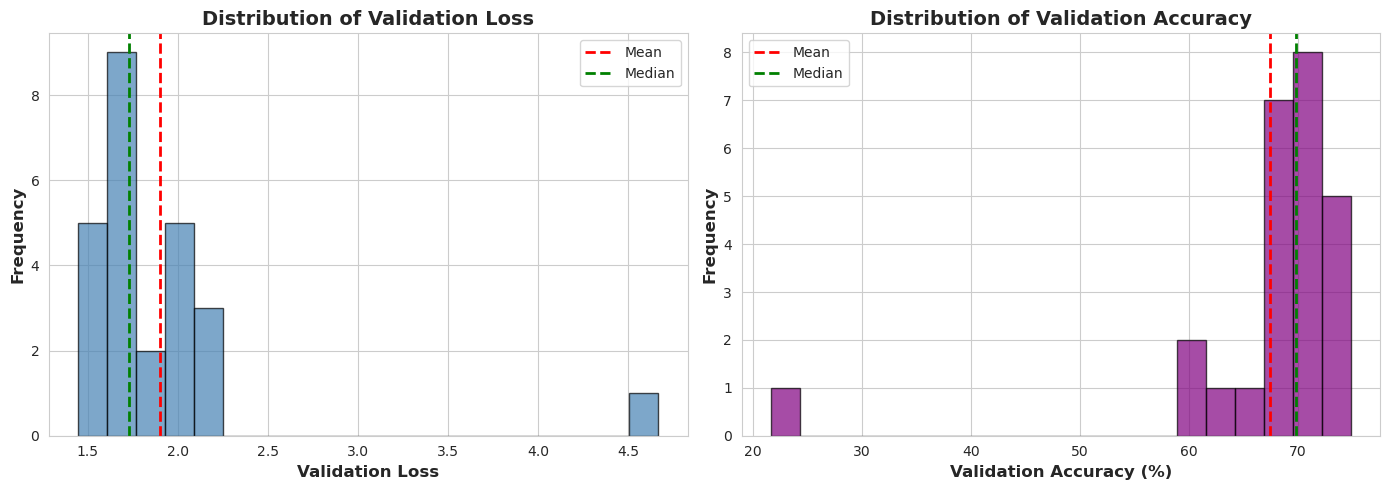

In [7]:
# Distribution of results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss distribution
axes[0].hist(df_experiments['val_loss'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(df_experiments['val_loss'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(df_experiments['val_loss'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[0].set_xlabel('Validation Loss', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()

# Accuracy distribution
axes[1].hist(df_experiments['val_acc'], bins=20, edgecolor='black', alpha=0.7, color='purple')
axes[1].axvline(df_experiments['val_acc'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(df_experiments['val_acc'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[1].set_xlabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Statistical Summary

In [8]:
print("=" * 60)
print("STATISTICAL SUMMARY")
print("=" * 60)
print(f"\nTotal Experiments: {len(df_experiments)}")
print(f"\nValidation Loss:")
print(f"  Mean: {df_experiments['val_loss'].mean():.5f}")
print(f"  Std:  {df_experiments['val_loss'].std():.5f}")
print(f"  Min:  {df_experiments['val_loss'].min():.5f} (S3D {df_experiments.loc[df_experiments['val_loss'].idxmin(), 'id']})")
print(f"  Max:  {df_experiments['val_loss'].max():.5f} (S3D {df_experiments.loc[df_experiments['val_loss'].idxmax(), 'id']})")

print(f"\nValidation Accuracy:")
print(f"  Mean: {df_experiments['val_acc'].mean():.2f}%")
print(f"  Std:  {df_experiments['val_acc'].std():.2f}%")
print(f"  Min:  {df_experiments['val_acc'].min():.2f}% (S3D {df_experiments.loc[df_experiments['val_acc'].idxmin(), 'id']})")
print(f"  Max:  {df_experiments['val_acc'].max():.2f}% (S3D {df_experiments.loc[df_experiments['val_acc'].idxmax(), 'id']})")

print(f"\nResults Distribution:")
for change_type in df_experiments['change'].unique():
    count = (df_experiments['change'] == change_type).sum()
    print(f"  {change_type.capitalize()}: {count} ({count/len(df_experiments)*100:.1f}%)")

STATISTICAL SUMMARY

Total Experiments: 25

Validation Loss:
  Mean: 1.90212
  Std:  0.61881
  Min:  1.44793 (S3D 23)
  Max:  4.66636 (S3D 24)

Validation Accuracy:
  Mean: 67.44%
  Std:  10.23%
  Min:  21.60% (S3D 24)
  Max:  74.85% (S3D 33)

Results Distribution:
  Baseline: 1 (4.0%)
  Worse: 12 (48.0%)
  Better: 11 (44.0%)
  Much worse: 1 (4.0%)


## 6. Top Performers

In [9]:
print("=" * 60)
print("TOP 5 BY VALIDATION LOSS")
print("=" * 60)
top_loss = df_experiments.nsmallest(5, 'val_loss')[['id', 'name', 'val_loss', 'val_acc', 'config']]
for idx, row in top_loss.iterrows():
    print(f"\n{row['id']}. {row['name']}")
    print(f"   Loss: {row['val_loss']:.5f} | Acc: {row['val_acc']:.2f}%")
    print(f"   Config: {row['config']}")

print("\n" + "=" * 60)
print("TOP 5 BY VALIDATION ACCURACY")
print("=" * 60)
top_acc = df_experiments.nlargest(5, 'val_acc')[['id', 'name', 'val_loss', 'val_acc', 'config']]
for idx, row in top_acc.iterrows():
    print(f"\n{row['id']}. {row['name']}")
    print(f"   Loss: {row['val_loss']:.5f} | Acc: {row['val_acc']:.2f}%")
    print(f"   Config: {row['config']}")

TOP 5 BY VALIDATION LOSS

23. hframe_hwd_warmrestarts
   Loss: 1.44793 | Acc: 71.30%
   Config: Warm restarts, eta_min=0

37. wups_restarts_eps4
   Loss: 1.48990 | Acc: 70.71%
   Config: Warmups + restarts, eps=1e-4

35. wups_restarts_et0
   Loss: 1.52350 | Acc: 69.23%
   Config: Warmups + restarts, eta_min=0

26. hframe_hwd_leps7
   Loss: 1.54510 | Acc: 70.41%
   Config: Adam eps: 1e-2

28. hf_hwd_eps_wups_restarts
   Loss: 1.54990 | Acc: 69.82%
   Config: Warmups + Warm restarts

TOP 5 BY VALIDATION ACCURACY

33. hf_hwd_eps_dp07
   Loss: 1.66760 | Acc: 74.85%
   Config: Dropout: 0.7

20. hframe_hwd_leps4
   Loss: 1.72448 | Acc: 73.67%
   Config: Adam eps: 1e-5

31. hf_hwd_eps_dp04
   Loss: 1.68760 | Acc: 73.37%
   Config: Dropout: 0.4

21. hframe_hwd_leps5
   Loss: 1.66771 | Acc: 73.37%
   Config: Adam eps: 1e-4

32. hf_hwd_eps_dp06
   Loss: 1.72990 | Acc: 73.08%
   Config: Dropout: 0.6


## 7. Key Findings

Based on the experiments conducted:

### ✅ What Works:
- **Adam epsilon**: Optimal range is 1e-5 to 1e-4, with 1e-2 also showing good results
- **Learning rate scheduling**: Warmups + warm restarts with eta_min=0 shows consistent improvement
- **Dropout**: Range of 0.4-0.7 works well (0.7 achieved best accuracy at 74.85%)
- **Batch size**: Can use batch size of 8 with 32 frames and 224 width to reduce runtime

### ❌ What Doesn't Work:
- **Backbone learning rate**: Increasing by 10x significantly degrades performance
- **Very low dropout**: Dropout of 0.1 causes huge performance degradation
- **No LR scheduler**: Removing scheduler hurts performance

### 🎯 Best Overall:
- **Lowest loss**: S3D 23 (hframe_hwd_warmrestarts) - 1.44793
- **Highest accuracy**: S3D 33 (hf_hwd_eps_dp07) - 74.85%

## 8. Add New Experiments

Use the cell below to add new experiments as you run them.

In [ ]:
# Example: Add a new experiment
# Uncomment and modify the lines below to add your new experiment

# df_experiments = add_experiment(
#     name='your_experiment_name',
#     val_loss=1.234,
#     val_acc=75.67,
#     config='Description of hyperparameters',
#     conclusion='Your conclusion about this experiment',
#     change='better'  # Options: 'better', 'worse', 'much worse', 'baseline', 'unknown'
# )

# After adding, save the experiments
# save_experiments(df_experiments)

# Then re-run the visualization cells above to see updated plots

print("Ready to add new experiments!")
print("\nUsage:")
print("1. Uncomment the add_experiment() call above")
print("2. Fill in your experiment details")
print("3. Run this cell")
print("4. Run save_experiments(df_experiments)")
print("5. Re-run visualization cells to see updates")

## 9. Quick Add Template

For faster data entry, use this template:

In [ ]:
# Quick add multiple experiments at once
new_experiments = [
    # Uncomment and modify these examples:
    # {
    #     'name': 'experiment_name_1',
    #     'val_loss': 1.50,
    #     'val_acc': 72.5,
    #     'config': 'eps=1e-5, dropout=0.5',
    #     'conclusion': 'Slight improvement',
    #     'change': 'better'
    # },
    # {
    #     'name': 'experiment_name_2',
    #     'val_loss': 1.60,
    #     'val_acc': 71.0,
    #     'config': 'eps=1e-6, dropout=0.5',
    #     'conclusion': 'Performance degraded',
    #     'change': 'worse'
    # },
]

# Add all experiments
for exp in new_experiments:
    df_experiments = add_experiment(**exp)

if new_experiments:
    save_experiments(df_experiments)
    print("\n✓ All experiments added and saved!")
else:
    print("No new experiments to add. Uncomment the examples above to get started.")

## 10. Compare Experiments

Compare specific experiments side-by-side:

In [ ]:
def compare_experiments(exp_ids):
    """Compare multiple experiments by their IDs"""
    comparison = df_experiments[df_experiments['id'].isin(exp_ids)].copy()
    
    if len(comparison) == 0:
        print("No experiments found with those IDs")
        return
    
    print("=" * 80)
    print("EXPERIMENT COMPARISON")
    print("=" * 80)
    
    for idx, row in comparison.iterrows():
        print(f"\n📊 S3D {row['id']}: {row['name']}")
        print(f"   Val Loss: {row['val_loss']:.5f}")
        print(f"   Val Acc:  {row['val_acc']:.2f}%")
        print(f"   Config:   {row['config']}")
        print(f"   Result:   {row['change']}")
        print(f"   Conclusion: {row['conclusion']}")
    
    # Statistical comparison
    print("\n" + "=" * 80)
    print("STATISTICS")
    print("=" * 80)
    print(f"Best Loss: {comparison['val_loss'].min():.5f} (S3D {comparison.loc[comparison['val_loss'].idxmin(), 'id']})")
    print(f"Best Acc:  {comparison['val_acc'].max():.2f}% (S3D {comparison.loc[comparison['val_acc'].idxmax(), 'id']})")
    print(f"Loss Range: {comparison['val_loss'].max() - comparison['val_loss'].min():.5f}")
    print(f"Acc Range:  {comparison['val_acc'].max() - comparison['val_acc'].min():.2f}%")
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    x_labels = [f"S3D {i}" for i in comparison['id']]
    
    axes[0].bar(x_labels, comparison['val_loss'], color='steelblue', edgecolor='black')
    axes[0].set_ylabel('Validation Loss', fontweight='bold')
    axes[0].set_title('Loss Comparison', fontweight='bold')
    axes[0].tick_params(axis='x', rotation=45)
    
    axes[1].bar(x_labels, comparison['val_acc'], color='purple', edgecolor='black')
    axes[1].set_ylabel('Validation Accuracy (%)', fontweight='bold')
    axes[1].set_title('Accuracy Comparison', fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Example: Compare experiments 13, 20, 23, 33
compare_experiments([13, 20, 23, 33])

## 11. Export Results

Export your experiments to CSV for external analysis:

In [ ]:
# Export to CSV
csv_filename = 'experiments_export.csv'
df_experiments.to_csv(csv_filename, index=False)
print(f"✓ Exported {len(df_experiments)} experiments to {csv_filename}")

# Also create a summary report
summary_filename = 'experiment_summary.txt'
with open(summary_filename, 'w') as f:
    f.write("S3D EXPERIMENT SUMMARY\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Total Experiments: {len(df_experiments)}\n")
    f.write(f"Date Range: {df_experiments['date'].min()} to {df_experiments['date'].max()}\n\n")
    
    f.write("BEST PERFORMERS:\n")
    f.write("-" * 60 + "\n")
    best_loss = df_experiments.loc[df_experiments['val_loss'].idxmin()]
    f.write(f"Best Loss: S3D {best_loss['id']} - {best_loss['name']}\n")
    f.write(f"  Loss: {best_loss['val_loss']:.5f}, Acc: {best_loss['val_acc']:.2f}%\n")
    f.write(f"  Config: {best_loss['config']}\n\n")
    
    best_acc = df_experiments.loc[df_experiments['val_acc'].idxmax()]
    f.write(f"Best Accuracy: S3D {best_acc['id']} - {best_acc['name']}\n")
    f.write(f"  Loss: {best_acc['val_loss']:.5f}, Acc: {best_acc['val_acc']:.2f}%\n")
    f.write(f"  Config: {best_acc['config']}\n\n")
    
    f.write("STATISTICS:\n")
    f.write("-" * 60 + "\n")
    f.write(f"Mean Loss: {df_experiments['val_loss'].mean():.5f} (±{df_experiments['val_loss'].std():.5f})\n")
    f.write(f"Mean Accuracy: {df_experiments['val_acc'].mean():.2f}% (±{df_experiments['val_acc'].std():.2f}%)\n\n")
    
    f.write("RESULTS DISTRIBUTION:\n")
    f.write("-" * 60 + "\n")
    for change_type in df_experiments['change'].unique():
        count = (df_experiments['change'] == change_type).sum()
        f.write(f"{change_type.capitalize()}: {count} ({count/len(df_experiments)*100:.1f}%)\n")

print(f"✓ Created summary report: {summary_filename}")

## 12. Search Experiments

Find experiments by keyword:

In [ ]:
def search_experiments(keyword, column='config'):
    """Search experiments by keyword in specified column"""
    results = df_experiments[df_experiments[column].str.contains(keyword, case=False, na=False)]
    
    if len(results) == 0:
        print(f"No experiments found containing '{keyword}' in {column}")
        return None
    
    print(f"Found {len(results)} experiment(s) containing '{keyword}':")
    print("\n" + "=" * 80)
    
    for idx, row in results.iterrows():
        print(f"\nS3D {row['id']}: {row['name']}")
        print(f"  Val Loss: {row['val_loss']:.5f} | Val Acc: {row['val_acc']:.2f}%")
        print(f"  Config: {row['config']}")
        print(f"  Conclusion: {row['conclusion']}")
    
    return results

# Example searches
print("Search for 'dropout' experiments:")
search_experiments('dropout')

print("\n" + "=" * 80 + "\n")
print("Search for 'warmup' experiments:")
search_experiments('warmup')

## 13. Notes & Future Directions

Use this section to jot down ideas for future experiments:

### Observations:
- Runtime increases with better-performing runs
- Type in scheduler added as an after effect
- Drop_p between 0.4-0.7 seems to be the sweet spot

### Future Experiments to Try:
1. Combine best settings: dropout=0.7, eps=1e-4, warmups + warm restarts with eta_min=0
2. Explore weight decay values between 1e-4 and 1e-3
3. Test different T_0 values for warm restarts
4. Try gradient clipping
5. Experiment with different backbone architectures

### Questions to Investigate:
- Why does dropout=0.1 fail so badly?
- Can we push batch size higher with gradient accumulation?
- Is there a correlation between runtime and performance?

---
*Add your own notes below:*

